## SMWA Project - Zomato Restaurants Review Analysis

#### Subham Sarangi

### (1) Data Understanding

#### <font color='Green'>1. Loading Libraries</font>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, adjusted_rand_score

# Import classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import LatentDirichletAllocation

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

#### <font color='Green'>2. Importing Dataset</font>

In [38]:
data_df = pd.read_csv("Restaurant_reviews.csv")

#### <font color='Green'>3. Exploratory Data Analysis and Data Pre-processing</font>

In [39]:
# 1: Five top records of data
data_df.head()

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures  
0   1 Review , 2 Followers  5/25/2019 15:54         0  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0  
3    1 Review , 1 Follower  5/24/2019 22:11         0  
4  3 Reviews , 2 Followers  5/24/2019 21:37         0

In [40]:
# Dropping unnecessary columns
data_df.drop(data_df.columns[-3:], axis='columns',  inplace = True)

In [41]:
# 2: Length of the dataset

print('length of data is', len(data_df))

length of data is 10000


In [42]:
# 3: Shape of data
data_df.shape

(10000, 4)

In [43]:
# 4: Size of data
data_df.size

40000

In [44]:
# 5: Data information
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
dtypes: object(4)
memory usage: 312.6+ KB


In [45]:
# 6: Handling null values
data_df.isnull().sum()

Restaurant     0
Reviewer      38
Review        45
Rating        38
dtype: int64

In [46]:
#Drop Rows which has null values

data_df.dropna(how='any',inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9955 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  9955 non-null   object
 1   Reviewer    9955 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9955 non-null   object
dtypes: object(4)
memory usage: 388.9+ KB


In [47]:
# 7: Check unique target values
data_df['Rating'].unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like'],
      dtype=object)

In [48]:
# 8: Remove Row which has Rating = Like as it is has just one

data_df = data_df[data_df["Rating"] != "Like"]
data_df["Rating"].value_counts()

5      3826
4      2373
1      1735
3      1192
2       684
4.5      69
3.5      47
2.5      19
1.5       9
Name: Rating, dtype: int64

In [49]:
# 9: Convert Rating Data Type to float

data_df["Rating"] = data_df["Rating"].astype("float")

In [50]:
# Replacing the float rating values to integer values.
# 1.5: 2, 2.5: 3, 3.5:4, 4.5-5
data_df["Rating"] = data_df["Rating"].replace(to_replace = [1.5,2.5,3.5,4.5], value = [2,3,4,5])
data_df["Rating"].value_counts()

5.0    3895
4.0    2420
1.0    1735
3.0    1211
2.0     693
Name: Rating, dtype: int64

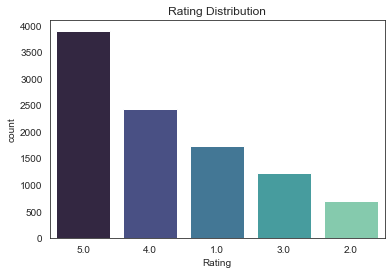

In [51]:
# 10: Data Visualization of Target Variables
plt.figure(figsize=(6,4))

sns.countplot(data=data_df,
              x='Rating',
              palette="mako",
              order = data_df['Rating'].value_counts().index)

plt.title('Rating Distribution')

plt.show()

In [52]:
# 11: Review Length Distribution for Different Ratings

# Length of word in sentence
data_df['Length'] = data_df['Review'].apply(lambda r: len(r.split(" ")))
data_df.head()

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review  Rating  Length  
0  The ambience was good, food was quite good . h...     5.0      39  
1  Ambience is too good for a pleasant evening. S...     5.0      27  
2  A must try.. great food great ambience. Thnx f...     5.0      31  
3  Soumen das and Arun was a great guy. Only beca...     5.0      28  
4  Food is good.we ordered Kodi drumsticks and ba...     5.0      27

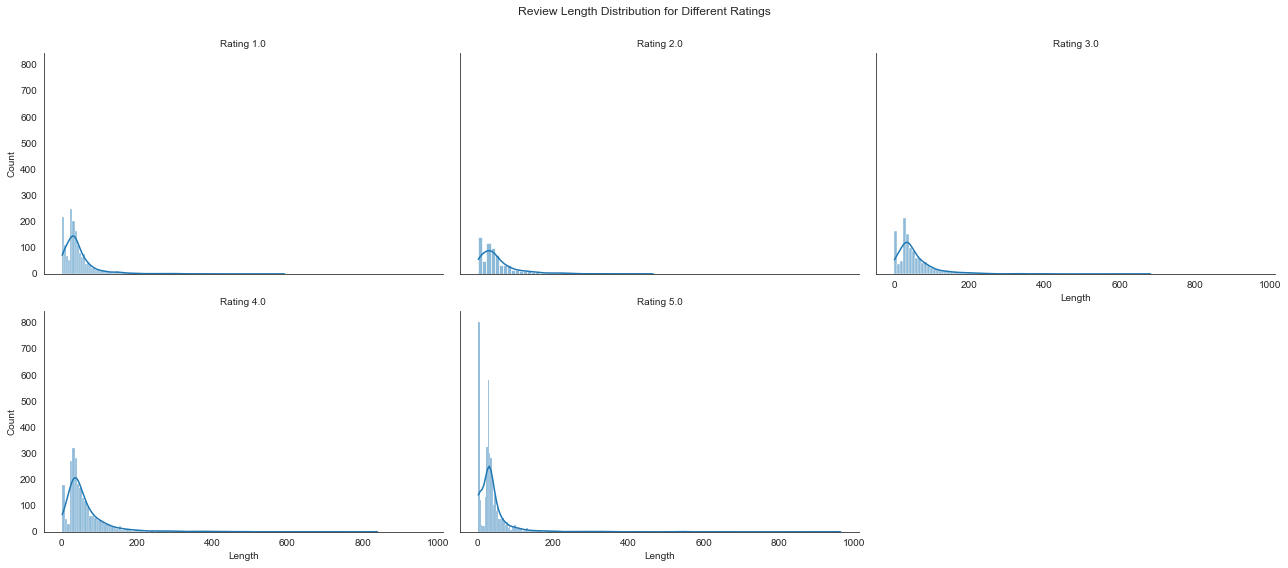

In [53]:
sns.set_style('white')
g = sns.FacetGrid(data_df, col='Rating',col_wrap=3, height=4, aspect=1.5)
g.map(sns.histplot, 'Length', kde=True)
g.set_axis_labels('Length', 'Count')
g.set_titles('Rating {col_name}')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Review Length Distribution for Different Ratings')
plt.show()

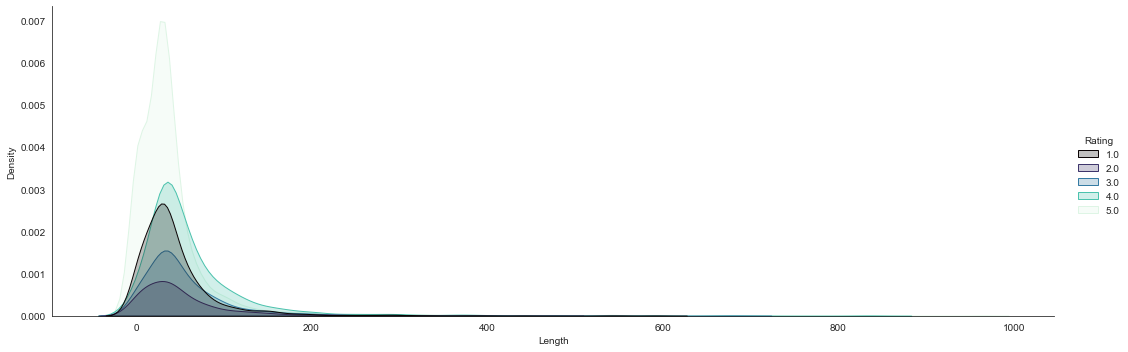

In [54]:
sns.displot(data=data_df, x='Length', hue='Rating', palette='mako', kind='kde', fill=True, aspect=3)

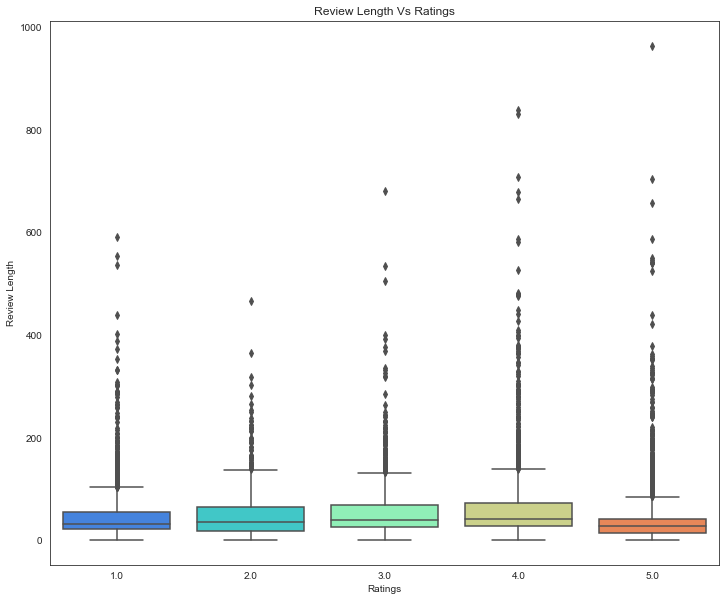

In [55]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'Rating', y='Length', data=data_df , palette='rainbow')
# Set axis labels and title
plt.xlabel('Ratings')
plt.ylabel('Review Length')
plt.title('Review Length Vs Ratings')

plt.show()

### (2) Sentiment Analysis

#### <font color='Green'>1. Sentiment Analysis using VADER </font>

We will perform sentiment analysis to analyze sentiment of each review and classify it as positive, negative, or neutral. And results will be compared with the real rating of the restaurants.

In [56]:
# Import Sentiment Analyzer - VADER 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [57]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Error loading vader_lexicon: <urlopen error [WinError
[nltk_data]     10060] A connection attempt failed because the
[nltk_data]     connected party did not properly respond after a
[nltk_data]     period of time, or established connection failed
[nltk_data]     because connected host has failed to respond>


False

In [58]:
# Defined a function to classify the sentiment of a review

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Analyze sentiments using VADER
def get_sentiment(review):
    scores = sia.polarity_scores(review)
    sentiment_score = scores['compound']
    if sentiment_score > 0.1:
        return 'positive'
    elif sentiment_score < -0.1:
        return 'negative'
    else:
        return 'neutral'
    
# Apply function on dataset copy
data_df = data_df.copy()
data_df['Predicted_Sentiment'] = data_df['Review'].apply(get_sentiment)

# Print the number of positive, negative, and neutral reviews
print("Number of positive reviews:", len(data_df[data_df['Predicted_Sentiment'] == 'positive']))
print("Number of negative reviews:", len(data_df[data_df['Predicted_Sentiment'] == 'negative']))
print("Number of neutral reviews:", len(data_df[data_df['Predicted_Sentiment'] == 'neutral']))

Number of positive reviews: 7335
Number of negative reviews: 1792
Number of neutral reviews: 827


In [59]:
data_df

Restaurant              Reviewer  \
0      Beyond Flavours     Rusha Chakraborty   
1      Beyond Flavours  Anusha Tirumalaneedi   
2      Beyond Flavours       Ashok Shekhawat   
3      Beyond Flavours        Swapnil Sarkar   
4      Beyond Flavours                Dileep   
...                ...                   ...   
9995  Chinese Pavilion      Abhishek Mahajan   
9996  Chinese Pavilion        Sharad Agrawal   
9997  Chinese Pavilion             Ramandeep   
9998  Chinese Pavilion       Nayana Shanbhag   
9999  Chinese Pavilion      Bhargava Krishna   

                                                 Review  Rating  Length  \
0     The ambience was good, food was quite good . h...     5.0      39   
1     Ambience is too good for a pleasant evening. S...     5.0      27   
2     A must try.. great food great ambience. Thnx f...     5.0      31   
3     Soumen das and Arun was a great guy. Only beca...     5.0      28   
4     Food is good.we ordered Kodi drumsticks and ba...     5.0      27   
...                                                 ...     ...     ...   
9995  Madhumathi Mahajan Well to start with nice cou...     3.0     189   
9996  This place has never disappointed us.. The foo...     5.0      52   
9997  Bad rating is mainly because of "Chicken Bone ...     2.0     267   
9998  I personally love and prefer Chinese Food. Had...     4.0      86   
9999  Checked in here to try some delicious chinese ...     4.0      85   

     Predicted_Sentiment  
0               positive  
1               positive  
2               positive  
3               positive  
4               positive  
...                  ...  
9995            positive  
9996            positive  
9997            positive  
9998            positive  
9999            positive  

[9954 rows x 6 columns]

In [60]:
# Mapping the rating column to create new column true sentiment
data_df['Actual_Sentiment'] = data_df['Rating'].map({1: 'negative', 
                                           2: 'negative', 
                                           3: 'neutral', 
                                           4: 'positive', 
                                           5: 'positive'})

In [61]:
data_df.head(10)

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   
5  Beyond Flavours         Nagabhavani K   
6  Beyond Flavours       Jamuna Bhuwalka   
7  Beyond Flavours             Sandhya S   
8  Beyond Flavours          Akash Thorat   
9  Beyond Flavours        Smarak Patnaik   

                                              Review  Rating  Length  \
0  The ambience was good, food was quite good . h...     5.0      39   
1  Ambience is too good for a pleasant evening. S...     5.0      27   
2  A must try.. great food great ambience. Thnx f...     5.0      31   
3  Soumen das and Arun was a great guy. Only beca...     5.0      28   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0      27   
5  Ambiance is good, service is good, food is aPr...     5.0      27   
6  Its a very nice place, ambience is different, ...     5.0      31   
7  Well after reading so many reviews finally vis...     4.0      47   
8  Excellent food , specially if you like spicy f...     5.0      34   
9  Came for the birthday treat of a close friend....     5.0      53   

  Predicted_Sentiment Actual_Sentiment  
0            positive         positive  
1            positive         positive  
2            positive         positive  
3            positive         positive  
4            positive         positive  
5            positive         positive  
6            positive         positive  
7            positive         positive  
8            positive         positive  
9            positive         positive

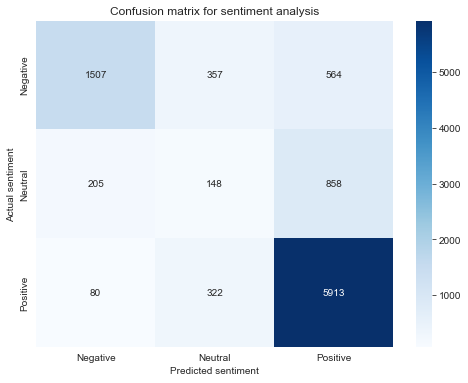

In [62]:
# Plotting confusion matrix
cm = confusion_matrix(data_df['Actual_Sentiment'], data_df['Predicted_Sentiment'])

plt.figure(figsize=(8,6))
# Create heatmap
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted sentiment')
plt.ylabel('Actual sentiment')
plt.title('Confusion matrix for sentiment analysis')
plt.show()

#### <font color='Green'>2. Sentiment Analysis using NRClex (NRC Emotion Lexicon)</font>

In [63]:
from nrclex import NRCLex

In [64]:
# Analyze sentiments and emotions using NRClex
sentiments = []

for review in data_df['Review']:
    emotion_analyzer = NRCLex(review)
    emotions = emotion_analyzer.affect_frequencies
    sentiments.append(emotions)

# Create a new DataFrame with sentiment information
sentiments_df = pd.DataFrame(sentiments)

# Combine with the original DataFrame
result_df = pd.concat([data_df, sentiments_df], axis=1)

In [65]:
result_df.head(10)

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   
5  Beyond Flavours         Nagabhavani K   
6  Beyond Flavours       Jamuna Bhuwalka   
7  Beyond Flavours             Sandhya S   
8  Beyond Flavours          Akash Thorat   
9  Beyond Flavours        Smarak Patnaik   

                                              Review  Rating  Length  \
0  The ambience was good, food was quite good . h...     5.0    39.0   
1  Ambience is too good for a pleasant evening. S...     5.0    27.0   
2  A must try.. great food great ambience. Thnx f...     5.0    31.0   
3  Soumen das and Arun was a great guy. Only beca...     5.0    28.0   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0    27.0   
5  Ambiance is good, service is good, food is aPr...     5.0    27.0   
6  Its a very nice place, ambience is different, ...     5.0    31.0   
7  Well after reading so many reviews finally vis...     4.0    47.0   
8  Excellent food , specially if you like spicy f...     5.0    34.0   
9  Came for the birthday treat of a close friend....     5.0    53.0   

  Predicted_Sentiment Actual_Sentiment      fear     anger  anticip     trust  \
0            positive         positive  0.000000  0.000000      0.0  0.263158   
1            positive         positive  0.000000  0.000000      0.0  0.181818   
2            positive         positive  0.000000  0.000000      0.0  0.285714   
3            positive         positive  0.000000  0.000000      0.0  0.222222   
4            positive         positive  0.000000  0.000000      0.0  0.200000   
5            positive         positive  0.000000  0.000000      0.0  0.214286   
6            positive         positive  0.000000  0.000000      0.0  0.142857   
7            positive         positive  0.000000  0.043478      0.0  0.130435   
8            positive         positive  0.000000  0.000000      0.0  0.416667   
9            positive         positive  0.044444  0.044444      0.0  0.133333   

   surprise  positive  negative   sadness   disgust       joy  anticipation  
0  0.105263  0.315789  0.000000  0.000000  0.000000  0.210526      0.105263  
1  0.181818  0.227273  0.000000  0.000000  0.000000  0.227273      0.181818  
2  0.000000  0.285714  0.000000  0.142857  0.000000  0.285714           NaN  
3  0.111111  0.333333  0.000000  0.000000  0.000000  0.222222      0.111111  
4  0.200000  0.200000  0.000000  0.000000  0.000000  0.200000      0.200000  
5  0.178571  0.214286  0.000000  0.000000  0.000000  0.214286      0.178571  
6  0.000000  0.714286  0.000000  0.000000  0.000000  0.142857           NaN  
7  0.086957  0.260870  0.043478  0.043478  0.086957  0.173913      0.130435  
8  0.000000  0.333333  0.000000  0.000000  0.000000  0.250000           NaN  
9  0.111111  0.222222  0.044444  0.066667  0.044444  0.177778      0.111111

### (3) Data Cleaning and Preprocessing

In [66]:
# Dropping unnecessary columns

data_df.drop(data_df.columns[4], axis='columns',  inplace = True)
data_df.drop(data_df.columns[-1], axis='columns',  inplace = True)
data_df

Restaurant              Reviewer  \
0      Beyond Flavours     Rusha Chakraborty   
1      Beyond Flavours  Anusha Tirumalaneedi   
2      Beyond Flavours       Ashok Shekhawat   
3      Beyond Flavours        Swapnil Sarkar   
4      Beyond Flavours                Dileep   
...                ...                   ...   
9995  Chinese Pavilion      Abhishek Mahajan   
9996  Chinese Pavilion        Sharad Agrawal   
9997  Chinese Pavilion             Ramandeep   
9998  Chinese Pavilion       Nayana Shanbhag   
9999  Chinese Pavilion      Bhargava Krishna   

                                                 Review  Rating  \
0     The ambience was good, food was quite good . h...     5.0   
1     Ambience is too good for a pleasant evening. S...     5.0   
2     A must try.. great food great ambience. Thnx f...     5.0   
3     Soumen das and Arun was a great guy. Only beca...     5.0   
4     Food is good.we ordered Kodi drumsticks and ba...     5.0   
...                                                 ...     ...   
9995  Madhumathi Mahajan Well to start with nice cou...     3.0   
9996  This place has never disappointed us.. The foo...     5.0   
9997  Bad rating is mainly because of "Chicken Bone ...     2.0   
9998  I personally love and prefer Chinese Food. Had...     4.0   
9999  Checked in here to try some delicious chinese ...     4.0   

     Predicted_Sentiment  
0               positive  
1               positive  
2               positive  
3               positive  
4               positive  
...                  ...  
9995            positive  
9996            positive  
9997            positive  
9998            positive  
9999            positive  

[9954 rows x 5 columns]

In [67]:
def get_all_string(sentences): 
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = re.sub('[^A-Za-z0-9 ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = re.sub(r'nt', '', sentence)
    sentence = sentence.lower()
    return sentence 

def get_word(sentence):
    return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)

def remove_stopword(word_tokens):
    stopword_list = stopwords.words('english')
    filtered_tokens = []
    
    for word in word_tokens:
        if word not in stopword_list: 
            filtered_tokens.append(word) 
    return filtered_tokens 

def lemmatize_words(filtered_tokens):
    lemm = WordNetLemmatizer() 
    cleaned_tokens = [lemm.lemmatize(word) for word in filtered_tokens]
    return cleaned_tokens

In [68]:
def create_freq_df(cleaned_tokens): 
    fdist = nltk.FreqDist(cleaned_tokens)
    freq_df = pd.DataFrame.from_dict(fdist, orient='index')
    freq_df.columns = ['Frequency']
    freq_df.index.name = 'Term'
    freq_df = freq_df.sort_values(by=['Frequency'], ascending=False)
    freq_df = freq_df.reset_index()
    return freq_df

In [69]:
def preprocess(series):
    all_string = get_all_string(series)
    words = get_word(all_string)
    filtered_tokens = remove_stopword(words)
    cleaned_tokens = lemmatize_words(filtered_tokens)
    return cleaned_tokens

In [70]:
def plot_text_distribution(x_df, y_df, color, title, xaxis_text, yaxis_text):
    
    fig = px.bar(x=x_df, 
                y=y_df,
                color=y_df,
                text=y_df,
                color_continuous_scale=color)

    fig.update_layout(
        title_text=title,
        template='plotly_white',
        xaxis=dict(
            title=xaxis_text,
        ),
        yaxis=dict(
            title=yaxis_text,
        )
    )

    fig.update_traces(marker_line_color='black', 
                    marker_line_width=1.5, 
                    opacity=0.8)
    
    fig.show()

In [71]:
def create_wordcloud(freq_df, title, color):
    
    data = freq_df.set_index('Term').to_dict()['Frequency']
    
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800, 
               height=400, 
               max_words=100,
               colormap= color,
               max_font_size=200,
               min_font_size = 1 ,
               random_state=8888, 
               background_color='white').generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

### <font color='Green'>Word Cloud</font>

#### Positive Sentiment Text Distribution

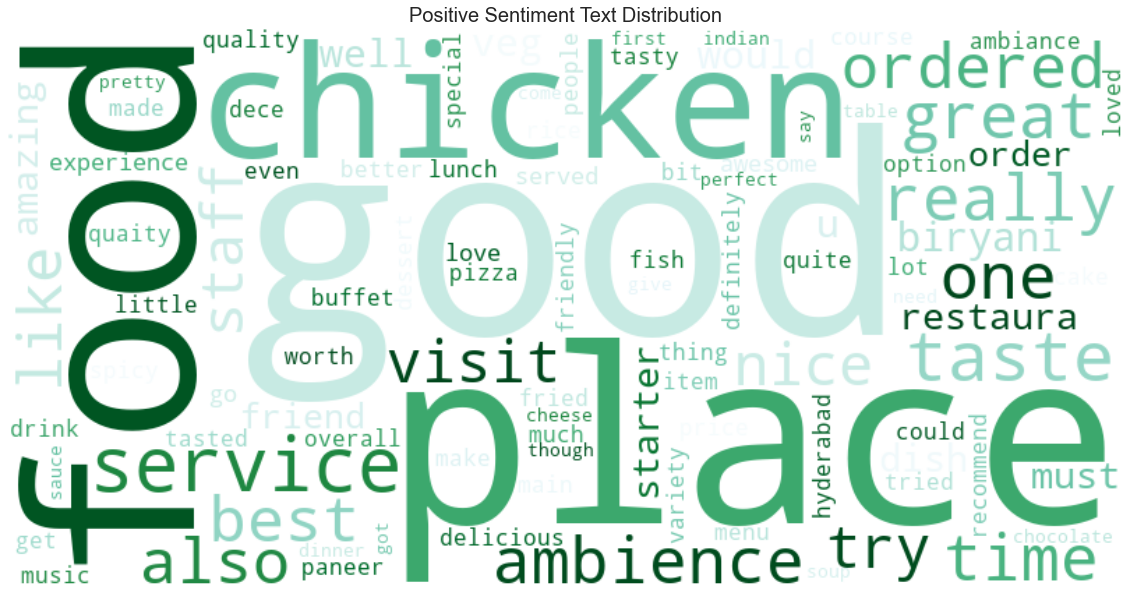

In [72]:
positive_words = preprocess(data_df.loc[data_df['Predicted_Sentiment'] == 'positive']['Review'])
positive_words
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                   'Greens', 'Top 10 Positive Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Sentiment Text Distribution', 'BuGn')


#### Negative Sentiment Text Distribution

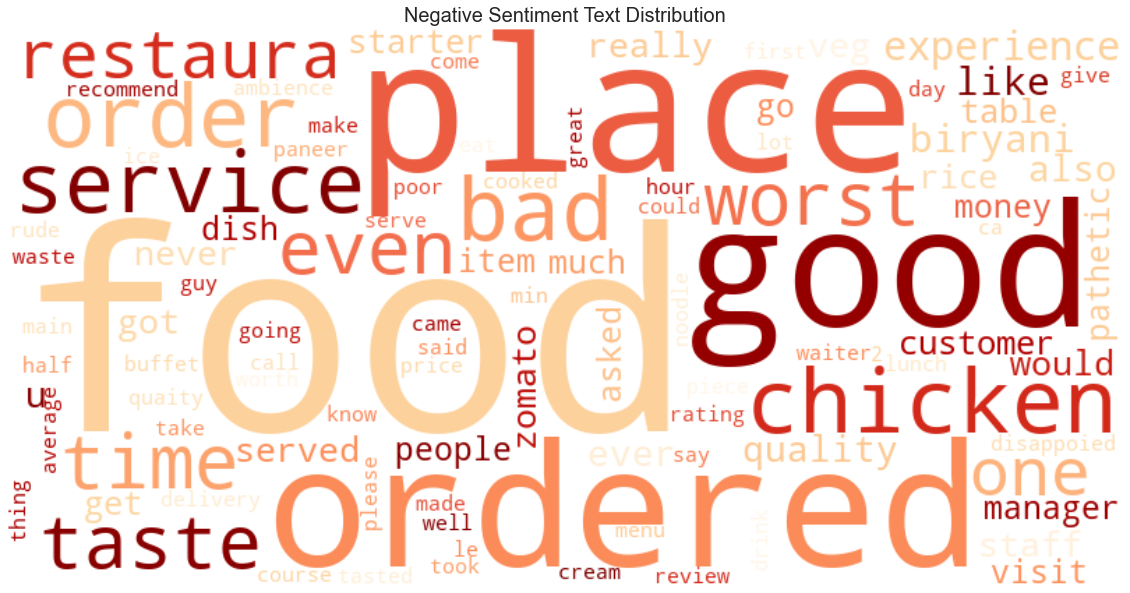

In [73]:
negative_words = preprocess(data_df.loc[data_df['Predicted_Sentiment'] == 'negative']['Review'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Sentiment Text Distribution', 'OrRd')

#### Neutral Sentiment Text Distribution

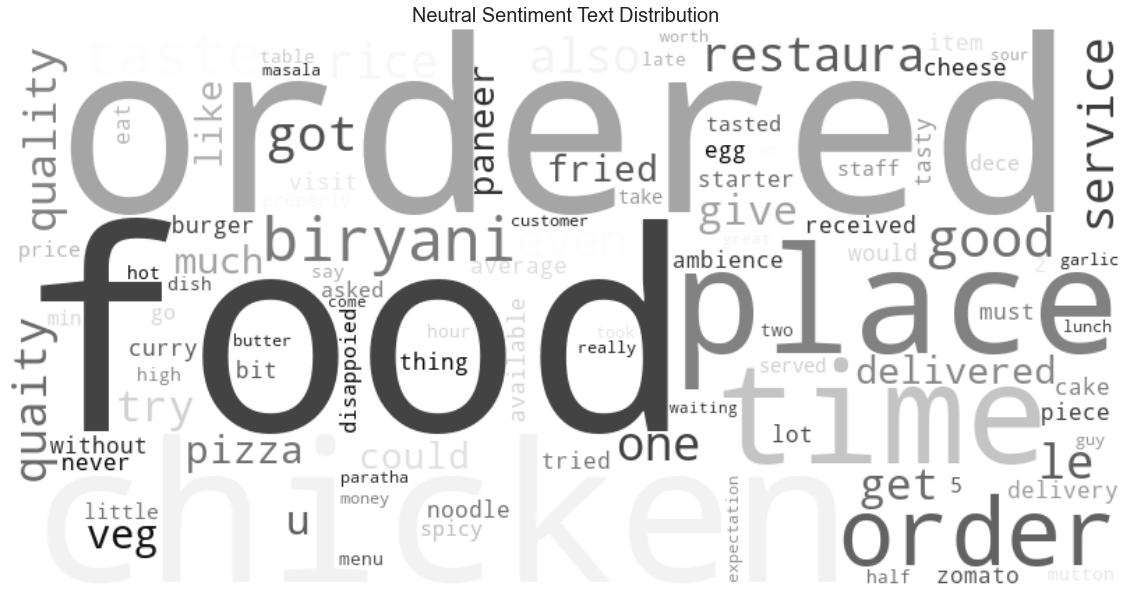

In [74]:
negative_words = preprocess(data_df.loc[data_df['Predicted_Sentiment'] == 'neutral']['Review'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Greys', 'Top 10 Neutral Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Neutral Sentiment Text Distribution', 'binary_r')

#### Overall Sentiment Text Distribution

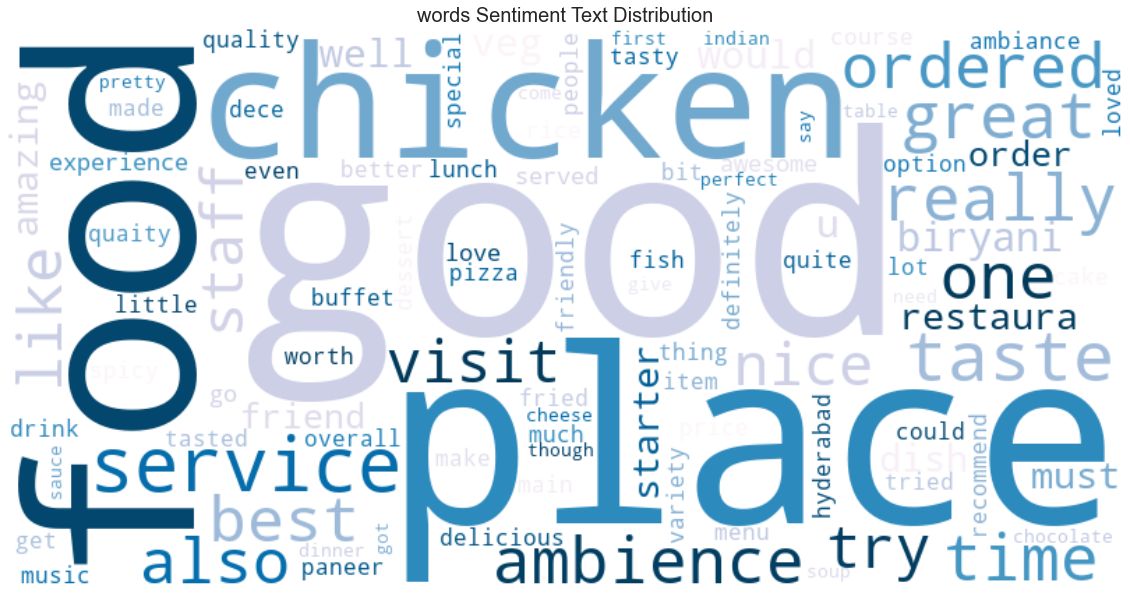

In [75]:
words = preprocess(data_df['Review'])
words
words_df = create_freq_df(words)
top10_words = words_df[:20]

plot_text_distribution(top10_words['Term'], top10_words['Frequency'],
                   'Blues', 'Top 20 words Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'words Sentiment Text Distribution', 'PuBu')

### (4) Data Modelling

 #### <font color='Green'>Transforming the Dataset Using TF-IDF Vectorizer</font>

In [76]:
# Prepare data for modeling
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(data_df['Review'])
y = data_df['Predicted_Sentiment']

#### <font color='Green'>Splitting the Data</font>

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=24)

 #### <font color='Green'>Model Building</font>

##### 1. Logistic Regression

In [78]:
# Build model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

predicted_lr = lr.predict(X_test)

# Calculate accuracy and print classification report
accuracy_lr = accuracy_score(y_test, predicted_lr)
print('Accuracy:', accuracy_lr)
print('\n')
print('Classification Report:')
print(classification_report(y_test, predicted_lr))

Accuracy: 0.8960321446509292


Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.70      0.76       350
     neutral       0.87      0.54      0.67       163
    positive       0.91      0.98      0.94      1478

    accuracy                           0.90      1991
   macro avg       0.87      0.74      0.79      1991
weighted avg       0.89      0.90      0.89      1991



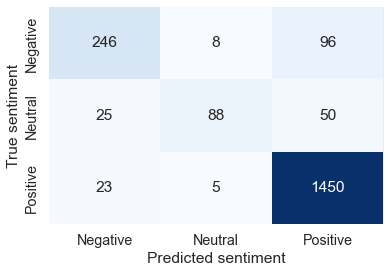

In [79]:
# Build confusion matrix
cm_lr = confusion_matrix(y_test, predicted_lr)

# Create heatmap
plt.figure(figsize = (6,4))
sns.set(font_scale = 1.3)
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

##### 2. Linear Support Vector Classification

In [80]:
# Build model
svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)

predicted_svc = svc.predict(X_test)

# Calculate accuracy and print classification report
accuracy_svc = accuracy_score(y_test, predicted_svc)
print('Accuracy:', accuracy_svc)
print('\n')
print('Classification Report:')
print(classification_report(y_test, predicted_svc))

Accuracy: 0.9090909090909091


Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.78      0.80       350
     neutral       0.80      0.67      0.73       163
    positive       0.94      0.97      0.95      1478

    accuracy                           0.91      1991
   macro avg       0.85      0.81      0.83      1991
weighted avg       0.91      0.91      0.91      1991



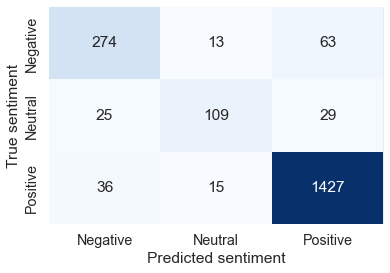

In [81]:
# Build confusion matrix
cm_svc = confusion_matrix(y_test, predicted_svc)

# Create heatmap
plt.figure(figsize = (6,4))
sns.set(font_scale = 1.3)
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

##### 3. Random Forest

In [82]:
# Build the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predicted_rf = rf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, predicted_rf)
print('Accuracy:', accuracy_rf)
print('\n')
print('Classification Report:')
print(classification_report(y_test, predicted_rf))

Accuracy: 0.8638874937217479


Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.51      0.64       350
     neutral       0.74      0.56      0.64       163
    positive       0.87      0.98      0.92      1478

    accuracy                           0.86      1991
   macro avg       0.83      0.69      0.74      1991
weighted avg       0.86      0.86      0.85      1991



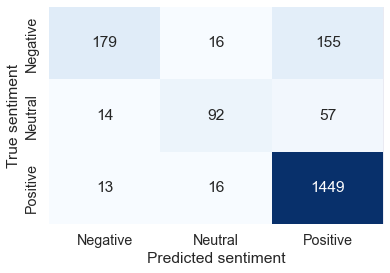

In [83]:
# Build confusion matrix
cm_rf = confusion_matrix(y_test, predicted_rf)

# heatmap
plt.figure(figsize = (6,4))
sns.set(font_scale = 1.3)
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

##### 4. Naive Bayes Multinominal

In [84]:
# Build the model
nb = MultinomialNB()
nb.fit(X_train, y_train)

predicted_nb = nb.predict(X_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, predicted_nb)
print('Accuracy:', accuracy_nb)
print('\n')
print('Classification Report:')
print(classification_report(y_test, predicted_nb))

Accuracy: 0.843294826720241


Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.61      0.70       350
     neutral       1.00      0.08      0.15       163
    positive       0.84      0.98      0.91      1478

    accuracy                           0.84      1991
   macro avg       0.89      0.56      0.59      1991
weighted avg       0.85      0.84      0.81      1991



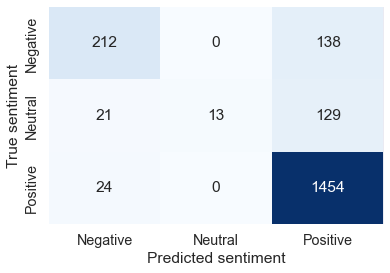

In [85]:
# Build confusion matrix
cm_nb = confusion_matrix(y_test, predicted_nb)

# Create heatmap
plt.figure(figsize = (6,4))
sns.set(font_scale = 1.3)
labels = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted sentiment')
plt.ylabel('True sentiment')
plt.show()

##### Compare models performance

In [86]:
Models = ['Logistic Regression', 'SVC', 'Random Forest', 'Naive Bayes Multinominal']
Scores = [accuracy_lr, accuracy_svc, accuracy_rf, accuracy_nb]
performance = pd.DataFrame(list(zip(Models, Scores)), 
                          columns = ['Models', 'Accuracy_score'])\
                            .sort_values('Accuracy_score', ascending=False)
performance

Models  Accuracy_score
1                       SVC        0.909091
0       Logistic Regression        0.896032
2             Random Forest        0.863887
3  Naive Bayes Multinominal        0.843295

### (5) Topic Modelling

In [87]:
# Preprocessing
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words = list(stop_words)
stop_words1 = ['placeholder_for_any_customize_words'] + stop_words
def preprocess(text):
    text = re.sub(r'\b\d+\b', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    text = [word for word in text.split() if word not in stop_words1]  # Remove stopwords
    return ' '.join(text)

In [88]:
data_df['preprocessed_reviews'] = data_df['Review'].apply(preprocess)

In [89]:
# Vectorization
vectorizer = CountVectorizer(ngram_range = (1,2), max_features=1000, max_df=0.5)
# see the above parameters and comment -- ? 

X = vectorizer.fit_transform(data_df['preprocessed_reviews'])

In [90]:
# LDA Model - This is used for Topic Modeling popularly 
# Specify beforehand the number of topics to be identified. This is given by number of components of LDA parameter
# set the 'K' - number of topics
number_of_topics = 5
lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [91]:
# Display topics and top words for each topic
feature_names = vectorizer.get_feature_names_out() # Get all the features/tokens names in vectorized data

num_words = 10            # Choose 'N' here the number of words to show for each LDA topic, to identify the topic 

for idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-num_words:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic {idx+1}: {', '.join(top_words)}")

Topic 1: food, order, ordered, bad, time, worst, delivery, restaurant, even, service
Topic 2: place, food, good, service, one, ambience, staff, would, menu, go
Topic 3: chicken, good, biryani, ordered, taste, rice, food, quantity, spicy, paneer
Topic 4: veg, starters, good, main, course, place, main course, one, cream, ice
Topic 5: good, food, place, service, great, ambience, nice, visit, staff, really


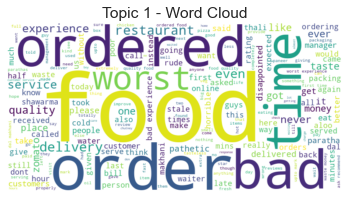

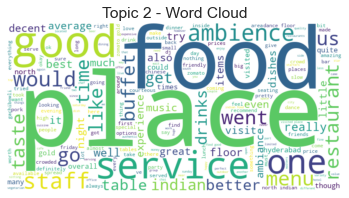

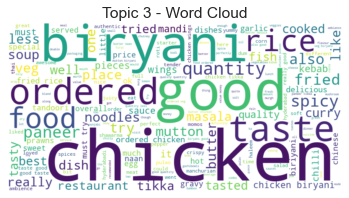

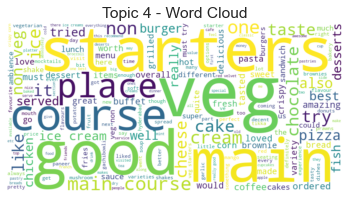

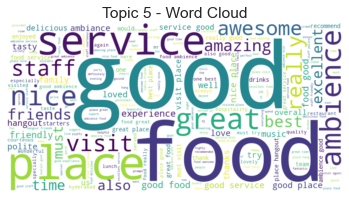

In [92]:
# Word Clouds for Topics
for idx, topic in enumerate(lda.components_):
    plt.figure(figsize=(6, 4))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(feature_names, topic)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {idx+1} - Word Cloud")
    plt.axis('off')
    plt.show()


### (6) Text clustering for reviews

We can use text clustering algorithms, such as K-means, to group similar reviews into clusters based on the similarity of their contents. The goal of clustering is to identify underlying patterns or structures in the data, which can be useful for recommendation systems, for example improving customer service.

In [93]:
# Choose only negative reviews
#df_neg = data_df[data_df['Rating'] <= 2]

# Convert text to numerical vectors using TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data_df['Review'])

# Cluster the documents using K-Means algorithm
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=100, n_init=1, random_state=42)
kmeans.fit(X)

# Evaluate the performance of the clustering using adjusted Rand index
y_true = data_df['Rating'].values
y_pred = kmeans.labels_
print('Adjusted Rand index:', adjusted_rand_score(y_true, y_pred))

Adjusted Rand index: 0.019577505893809237


In [94]:
# Reduce the dimensionality of the vectors to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

In [95]:
# Get top features for each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(optimal_clusters):
    print(f"Cluster {i+1} top terms:", [terms[ind] for ind in order_centroids[i, :10]])
    print('-------')

Cluster 1 top terms: ['chicken', 'good', 'food', 'taste', 'ordered', 'delivery', 'biryani', 'time', 'order', 'bad']
-------
Cluster 2 top terms: ['good', 'food', 'place', 'nice', 'service', 'great', 'ambience', 'staff', 'visit', 'really']
-------
Cluster 3 top terms: ['good', 'service', 'food', 'taste', 'time', 'earlier', 'little', 'quantity', 'biriyani', 'today']
-------


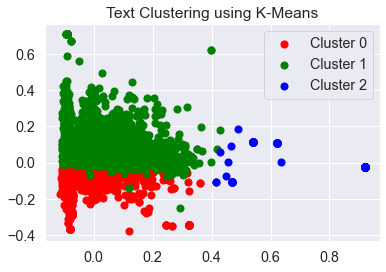

In [96]:
# Plot the clusters
colors = ['red', 'green', 'blue']
for i in range(optimal_clusters):
    plt.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], s=50, c=colors[i], label='Cluster {}'.format(i))
plt.legend()
plt.title('Text Clustering using K-Means')
plt.show()

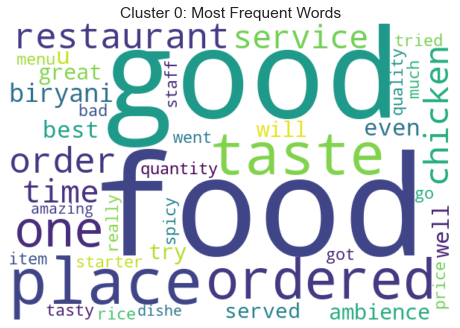

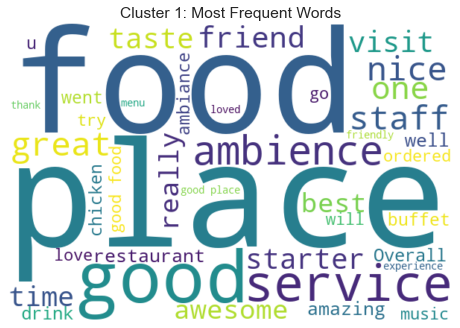

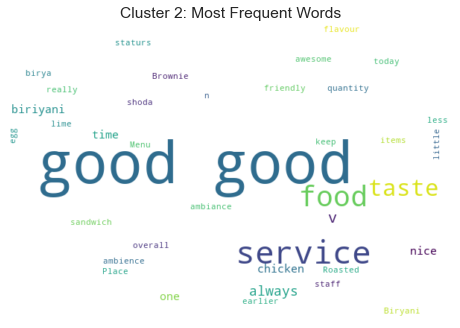

In [97]:
# Get the most frequent words in each cluster
top_words = 40
for i in range(optimal_clusters):
    cluster_reviews = data_df['Review'][kmeans.labels_ == i]
    cluster_text = ' '.join(cluster_reviews)
    wordcloud = WordCloud(width=600, height=400, max_words=top_words, background_color='white').generate(cluster_text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Cluster {}: Most Frequent Words'.format(i))
    plt.show()

In [98]:
# Find optimal number of clusters using silhouette score
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

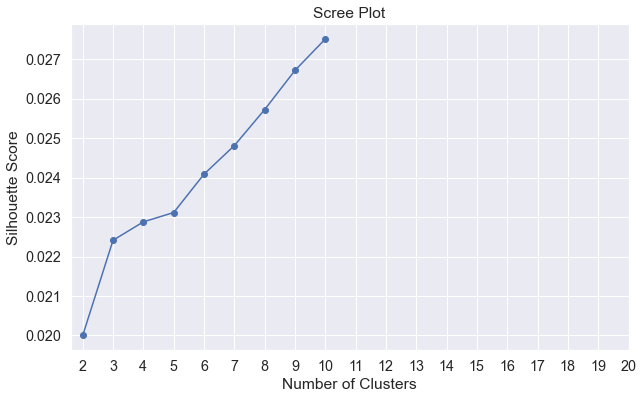

In [99]:
# Plot Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Scree Plot")
plt.xticks(range(2, 21))
plt.show()

Through silhouette score we identify that optimal number of clusters are 3.